# Deep-Q Neural Network Training

This notebook contains the code for training the deep neural network to represent the Connect-4 Q function. This comes after the Q-learning step, and uses the saved policy as training data to model a global Q function for any state.

# Setup

**Include Dependencies:**

In [34]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torcheval.metrics import MeanSquaredError
from torcheval.metrics import R2Score

**Define Constants:**

In [3]:
BOARD_ROWS = 7
BOARD_COLS = 8

In [4]:
# SET TO THE NAME OF THE GENERATED POLICY FILE
POLICY_NAME = 'policy'

# Data Loading / Preprocessing

Define functions to load a policy file and reconstruct matrices from hashes.

In [5]:
def loadPolicy(file):
  fr = open(file, 'rb')
  states_value = pickle.load(fr)
  fr.close()

  return states_value

def decode_hash(string):
  elts = string.strip('[]').split()
  elts = [int(x) for x in elts]

  arr = np.array(elts)
  arr = arr.reshape((BOARD_ROWS, BOARD_COLS))

  return arr

Change structure of Q table to be X/Y pairs. Create train/val split.

In [6]:
states_value = loadPolicy(POLICY_NAME)
X_all, Y_all = np.array(list(states_value.keys())), np.array(list(states_value.values()))

num_zeros = np.sum(Y_all == 0, axis=1)
mask = num_zeros <= 1

X_all, Y_all = X_all[mask], Y_all[mask]

X_train, X_val, Y_train, Y_val = train_test_split(X_all, Y_all, test_size=0.15)

len(Y_all)

128886

Define Torch Dataset class.

In [7]:
class PolicyDataset(Dataset):
  data_map = {
    'train': (X_train, Y_train),
    'val': (X_val, Y_val),
  }

  def __init__(self, mode='train'):
    self.mode = mode

  def __len__(self):
    return len(self.data_map[self.mode][0])

  def __getitem__(self, idx):
    board_hash = self.data_map[self.mode][0][idx]

    item = torch.tensor(decode_hash(board_hash))
    label = self.data_map[self.mode][1][idx]

    return item, label

# Neural Network
Training, evaluating, and saving the neural network.

## Definition

In [22]:
class ConnectNet(nn.Module):
    def __init__(self, h1_size, h2_size, dropout_p):
      super(ConnectNet, self).__init__()

      self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
      self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
      self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

      self.dropout1 = nn.Dropout2d(p=dropout_p)

      self.FLATTENED_SIZE = 256 * 7 * 8

      self.fc1 = nn.Linear(self.FLATTENED_SIZE, h1_size)

      self.dropout2 = nn.Dropout(p=dropout_p) 

      self.fc2 = nn.Linear(h1_size, h2_size)
      self.fc3 = nn.Linear(h2_size, 8)

    def forward(self, x):
      x = x.unsqueeze(1)

      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))

      x = self.dropout1(x)

      x = x.view(-1, self.FLATTENED_SIZE)

      x = F.relu(self.fc1(x))
      x = self.dropout2(x)

      x = F.relu(self.fc2(x))
      x = self.fc3(x)

      return x

## Training

In [26]:
learning_rate = 0.001
batch_size = 2056
num_epochs = 50

hidden1_size = 128
hidden2_size = 64

dropout_p = 0.15

In [27]:
train_set = PolicyDataset(mode='train')
val_set = PolicyDataset(mode='val')

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training Model
model = ConnectNet(hidden1_size, hidden2_size, dropout_p)
model = model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

print(f'Started training on {device}')

train_loss_epochs = []
val_loss_epochs = []

for epoch in range(num_epochs):
  model.train()
  train_loss = []
  val_loss = []

  for idx, batch in enumerate(train_dataloader):
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    inputs, labels = inputs.to(torch.float32), labels.to(torch.float32)

    output = model(inputs)
    output = output.squeeze(1)

    loss = loss_function(output, labels)

    optim.zero_grad()
    loss.backward()
    optim.step()

    train_loss.append(loss.item())

    model.eval()
    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
          inputs, labels = batch
          inputs, labels = inputs.to(device), labels.to(device)
          inputs, labels = inputs.to(torch.float32), labels.to(torch.float32)

          output = model(inputs)
          output = output.squeeze(1)

          loss = loss_function(output, labels)

          val_loss.append(loss.item())

  train_loss_epochs.append(np.mean(train_loss))
  val_loss_epochs.append(np.mean(val_loss))
  print("Epoch : {}, Train loss: {}, Val loss: {}".format(epoch, np.mean(train_loss), np.mean(val_loss)))


print('Done training.')

Started training on cuda
Epoch : 0, Train loss: 1.3092761293605522, Val loss: 1.350435216559304
Epoch : 1, Train loss: 1.2547036939197116, Val loss: 1.2971353791378162
Epoch : 2, Train loss: 1.2088522922109675, Val loss: 1.2653673476643033
Epoch : 3, Train loss: 1.1659331222375233, Val loss: 1.2087747755977842
Epoch : 4, Train loss: 1.0455719740302474, Val loss: 1.0722330459841976
Epoch : 5, Train loss: 1.00311157990385, Val loss: 1.0460468415860777
Epoch : 6, Train loss: 0.9292074927577266, Val loss: 0.983268897290583
Epoch : 7, Train loss: 0.8751041315220021, Val loss: 0.9352186016462467
Epoch : 8, Train loss: 0.87185948866385, Val loss: 0.9298723447102087
Epoch : 9, Train loss: 0.8355749392950976, Val loss: 0.8974766136319549
Epoch : 10, Train loss: 0.8166882318479044, Val loss: 0.8779460742517754
Epoch : 11, Train loss: 0.7874545079690439, Val loss: 0.848816270408807
Epoch : 12, Train loss: 0.7849935524993472, Val loss: 0.8476607352495193
Epoch : 13, Train loss: 0.7614364944122456,

## Evaluation

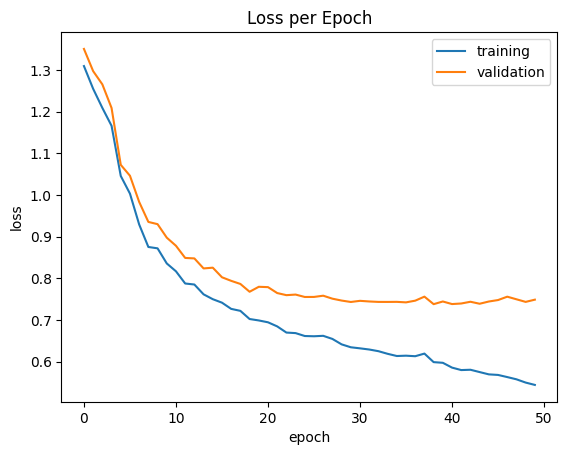

In [28]:
plt.plot(np.squeeze(train_loss_epochs), label='training')
plt.plot(np.squeeze(val_loss_epochs), label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Loss per Epoch')
plt.legend(loc='best')

plt.show()

In [ ]:
model.eval()
model.to('cpu')

In [33]:
def calc_torch_metric(metric_class, **kwargs):
    train_result, val_result = None, None

    train_all_loader = DataLoader(train_set, batch_size=len(Y_train), shuffle=False)
    val_all_loader = DataLoader(val_set, batch_size=len(Y_val), shuffle=False)

    train_X, train_Y = next(iter(train_all_loader))
    train_X, train_Y = train_X.to(torch.float32), train_Y.to(torch.float32)
    train_Y_hat = model(train_X)

    metric = metric_class(**kwargs)

    metric.update(train_Y_hat, train_Y)
    train_result = metric.compute()

    val_X, val_Y = next(iter(val_all_loader))
    val_X, val_Y = val_X.to(torch.float32), val_Y.to(torch.float32)
    val_Y_hat = model(val_X)

    metric.update(val_Y_hat, val_Y)
    val_result = metric.compute()

    return train_result, val_result

In [35]:
train_mse, val_mse = calc_torch_metric(MeanSquaredError)
print('Train MSE: ', train_mse.item())
print('Val MSE: ', val_mse.item())

Train MSE:  0.5444692373275757
Val MSE:  0.5776267647743225


In [36]:
train_r2, val_r2 = calc_torch_metric(R2Score)
print('Train R2: ', train_r2.item())
print('Val R2: ', val_r2.item())

print('Train R: ', train_r2.item() ** 0.5)
print('Val R: ', val_r2.item() ** 0.5)

Train R2:  0.5856567025184631
Val R2:  0.5628010034561157
Train R:  0.7652821064930652
Val R:  0.7502006421325669


## Save Model
Saving the learned weights.

In [14]:
torch.save(model.state_dict(), '../model.pt')